In [1]:
import os
import sqlalchemy as db
import geopandas as gpd
import pandas as pd
import osmnx
from shapely.geometry import box, LineString, Point
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
POSTGRES_HOST="xxxx"
POSTGRES_PORT="xxxx"
POSTGRES_DB="xxxx"
POSTGRES_SCHEMA="xxxx"
POSTGRES_USER="xxxx"
POSTGRES_PASSWORD="xxxx"

In [3]:
engine = db.create_engine('postgresql://{user}:{pw}@{host}/{db}'
                           .format(user=POSTGRES_USER,
                                   pw=POSTGRES_PASSWORD,
                                   host=POSTGRES_HOST,
                                   db=POSTGRES_DB,
                                   port=POSTGRES_PORT))

In [4]:
connection = engine.connect()

# Study area of South West Spain

	Course	Distance	Coordinate
1.	88.90°	88.64 nm	N 36.180° - W 8.511°
2.	359.74°	63.72 nm	N 37.241° - W 8.517°
3.	1.47°	11.18 nm	N 37.427° - W 8.511°
4.	269.86°	77.90 nm	N 37.413° - W 10.145°
5.	187.46°	75.10 nm	N 36.172° - W 10.346

In [5]:
min_lon = -8
min_lat = 36
max_lon= -11
max_lat=  38
bbox = box(min_lon, min_lat, max_lon, max_lat)
bbox_wkt = bbox.wkt
bbox_wkt

'POLYGON ((-11 36, -11 38, -8 38, -8 36, -11 36))'

In [12]:

query = "SELECT *,linestring AS geom FROM public.ways WHERE ST_Intersects(linestring, ST_GeomFromText('POLYGON ((-11 36, -11 38, -8 38, -8 36, -11 36))', 4326)) AND (tags -> 'seamark:type'='separation_boundary' OR tags -> 'seamark:type'='separation_line' OR tags -> 'seamark:type'='separation_zone' OR tags -> 'seamark:type'='separation_lane')"
#query = "SELECT *,linestring AS geom FROM public.ways WHERE ST_Intersects(linestring, ST_GeomFromText('POLYGON ((11 36, 11 38, 8 38, 8 36, 11 36))', 4326))"
#query = "SELECT *,linestring AS geom FROM public.ways WHERE tags -> 'seamark:type'='inshore_traffic_zone'"
gdf_ways = gpd.read_postgis(query, engine)
#gdf_ways = gpd.read_postgis(query, engine)


In [13]:
gdf_ways['tstamp']=gdf_ways['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
gdf_ways
gdf_ways.explore()

In [35]:
    filename = 'Data/route_3.geojson'
    with open(filename) as file:
        rp_dict = json.load(file)

    point_list = rp_dict['features']
    count = len(point_list)
    lats_per_step = np.full(count, -99, dtype=float)
    lons_per_step = np.full(count, -99, dtype=float)

    color_list = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
                  'lightred',
                  'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple',
                  'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black',
                  'lightgray']

    for ipoint in range(0, count):
        coord_pair = point_list[ipoint]['geometry']['coordinates']
        lats_per_step[ipoint] = coord_pair[1]
        lons_per_step[ipoint] = coord_pair[0]

    # Create LineString segments from X and Y columns
    segments = []
    for i in range(len(lons_per_step) - 1):
        segment = LineString([(lons_per_step[i], lats_per_step[i]),
                              (lons_per_step[i + 1], lats_per_step[i + 1])])
        segments.append(segment)

    # Add LineString segments to a new GeoDataFrame
    segments_gdf = gpd.GeoDataFrame(geometry=segments, crs="EPSG:4326")

    # Print the segments GeoDataFrame
    print(segments_gdf)


                                            geometry
0  LINESTRING (-9.55625 37.22111, -9.44425 37.11873)
1  LINESTRING (-9.44425 37.11873, -9.27839 36.99293)
2  LINESTRING (-9.27839 36.99293, -9.01753 36.51364)
3  LINESTRING (-9.01753 36.51364, -8.85348 36.47596)


In [36]:
seamark_gdf = gdf_ways 

seg geometry    LINESTRING (-9.556246648089939 37.221114597925...
Name: 0, dtype: object
interesct point id                                                      180750443
version                                                         1
user_id                                                     53936
tstamp                                        2012-09-12 20:55:29
changeset_id                                             13089009
tags                          {'seamark:type': 'separation_zone'}
nodes           [1912128998, 1912129002, 1912129033, 191212907...
linestring      0102000020E6100000090000000927B38BB3EF21C0E7FB...
bbox            0103000020E61000000100000005000000F4FDD478E9A6...
geometry             POINT (-9.313933178924199 37.01988819578168)
Name: 0, dtype: object
interesct point id                                                      180750443
version                                                         1
user_id                                                     5393

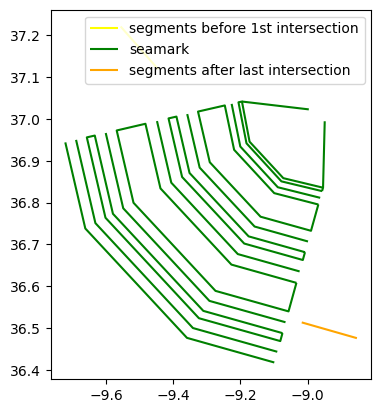

          x          y
0 -9.444253  37.118734
          x          y
3 -9.017529  36.513638


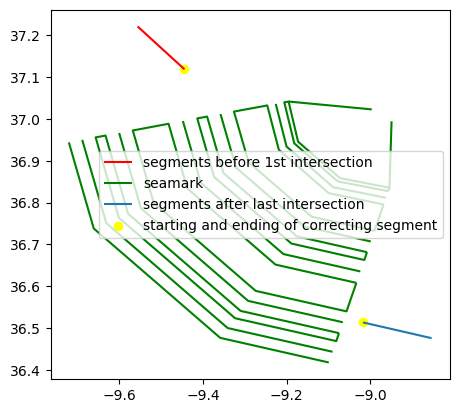

In [37]:
 # Perform spatial overlay to find intersections
intersection = gpd.overlay(segments_gdf, seamark_gdf, how='intersection',
                               keep_geom_type=False)


first_node = 0
indx_intersect = []
for index, seg in segments_gdf.iterrows():
    print('seg', seg)
    for j, inter_point in intersection.iterrows():
        print('interesct point', inter_point)
        buffered_point = inter_point.geometry.buffer(0.000001)
        val = seg.geometry.intersects(buffered_point)
        if (val):
            print('____________________________________________')
            indx_intersect.append(index)

print(indx_intersect)
segments_before_df = segments_gdf[0:indx_intersect[0]]

last_index = indx_intersect[len(indx_intersect) - 1]
last_index = last_index + 1
segments_after = segments_gdf[last_index:]

fig, ax = plt.subplots()
segments_before_df.plot(ax=ax, color='yellow',
                            label='segments before 1st intersection')
seamark_gdf.plot(ax=ax, color='green', label='seamark')
segments_after.plot(ax=ax, color = 'orange', label='segments after last intersection')
ax.legend()
plt.show()

first_node_line = segments_before_df.tail(1).geometry.get_coordinates()
point_start = first_node_line.tail(1)
print(point_start)
point_A = Point(point_start.x, point_start.y)

first_node_line = segments_after.head(1).geometry.get_coordinates()
point_end = first_node_line.head(1)
print(point_end)
point_B = Point(point_end.x, point_end.y)

points = [point_A, point_B]
p = gpd.GeoSeries(points)

fig, ax = plt.subplots()
segments_before_df.plot(ax=ax, color='red',
                            label='segments before 1st intersection')
seamark_gdf.plot(ax=ax, color='green', label='seamark')
segments_after.plot(ax=ax, label='segments after last intersection')
p.plot(ax=ax, color='yellow', label='starting and ending of correcting segment' )
ax.legend()
plt.show()

In [38]:
print(point_A)

POINT (-9.444252715896567 37.11873424980533)


In [39]:
print(point_B)

POINT (-9.017528720254575 36.513638062999206)


## Find the traffic separation lanes

In [45]:
query = "SELECT *,linestring AS geom FROM public.ways WHERE ST_Intersects(linestring, ST_GeomFromText( 'POLYGON ((-11 36, -11 38, -8 38, -8 36, -11 36))', 4326)) AND ( tags -> 'seamark:type'='separation_lane')"
gdf_ways = gpd.read_postgis(query, engine)
gdf_ways['tstamp']=gdf_ways['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
gdf_ways

,id,version,user_id,tstamp,changeset_id,tags,nodes,linestring,bbox,geom
0,180750436,1,53936,2012-09-12 20:55:28,13089009,{'seamark:type': 'separation_lane'},"[1912128972, 1912128981, 1912129031, 1912129064]",0102000020E61000000400000043DB7B0272FF21C01DB4...,0103000020E61000000100000005000000CE7CBDB156B7...,"LINESTRING (-8.99892 36.70709, -9.15775 36.742..."
1,180750437,1,53936,2012-09-12 20:55:28,13089009,{'seamark:type': 'separation_lane'},"[1912129071, 1912129034, 1912129010, 1912129000]",0102000020E610000004000000C1CAA145B67322C0D976...,0103000020E61000000100000005000000C1CAA145B673...,"LINESTRING (-9.22600 37.03608, -9.20025 36.934..."
2,180750438,1,53936,2012-09-12 20:55:29,13089009,{'seamark:type': 'separation_lane'},"[1912129041, 1912128996, 1912128962, 191212894...",0102000020E610000005000000CAF154D1693323C09EE6...,0103000020E61000000100000005000000CAF154D16933...,"LINESTRING (-9.60042 36.96642, -9.54842 36.786..."
3,180750440,1,53936,2012-09-12 20:55:29,13089009,{'seamark:type': 'separation_lane'},"[1912128954, 1912128964, 1912128986, 191212901...",0102000020E6100000050000008C1CD8E0330C22C0BB39...,0103000020E610000001000000050000004C37894160E5...,"LINESTRING (-9.02383 36.63550, -9.20767 36.677..."
4,180750441,1,53936,2012-09-12 20:55:29,13089009,{'seamark:type': 'separation_lane'},"[1912129038, 1912128984, 1912128953, 191212893...",0102000020E61000000500000041B0F4EB986023C0C318...,0103000020E6100000010000000500000041B0F4EB9860...,"LINESTRING (-9.68867 36.95000, -9.63117 36.751..."


In [46]:
gdf_ways.explore()


In [47]:
dist_list = []
for line in gdf_ways.geom:
    seamark_lane_segment = line
    x,y = seamark_lane_segment.xy
    seamark_start_point = Point(x[0], y[0])
    dist = point_A.distance(seamark_start_point)
    dist_list.append(dist)
    print(dist)

mind_dist_index = dist_list.index(min(dist_list))
print(mind_dist_index)

0.606446313658989
0.2333782572772578
0.21814620093592363
0.6405179048410528
0.29700063163067675
2


In [48]:
seperation_lane = gdf_ways.loc[mind_dist_index]
#seperation_lane_geom['geom'] =seperation_lane['geom']
print(type(seperation_lane))

<class 'pandas.core.series.Series'>


In [49]:
seperation_lane

id                                                      180750438
version                                                         1
user_id                                                     53936
tstamp                                        2012-09-12 20:55:29
changeset_id                                             13089009
tags                          {'seamark:type': 'separation_lane'}
nodes           [1912129041, 1912128996, 1912128962, 191212894...
linestring      0102000020E610000005000000CAF154D1693323C09EE6...
bbox            0103000020E61000000100000005000000CAF154D16933...
geom            LINESTRING (-9.6004167 36.9664169, -9.5484167 ...
Name: 2, dtype: object

In [50]:
from shapely.ops import linemerge

In [51]:
seperation_lane_geom = seperation_lane.geom

In [52]:
print(seperation_lane_geom)
print(type(seperation_lane_geom))

LINESTRING (-9.6004167 36.9664169, -9.5484167 36.7865011, -9.42025 36.6758737, -9.2920833 36.565087, -9.0658333 36.5140044)
<class 'shapely.geometry.linestring.LineString'>


In [53]:
print(type(segments_before_df))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [54]:
segments_after

,geometry
3,"LINESTRING (-9.01753 36.51364, -8.85348 36.47596)"


## =============================================================================

In [55]:
segments_before_df

,geometry
0,"LINESTRING (-9.55625 37.22111, -9.44425 37.11873)"


Shapely LineString: LINESTRING (-9.556246648089939 37.22111459792596, -9.444252715896567 37.11873424980533)


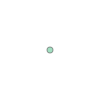

In [56]:
# Create ´connecting lines
last_line_start_seg = segments_before_df.tail(1)

geom =last_line_start_seg['geometry']
# Access one of the LineString geometries from the GeoSeries (for example, the first one)
line_gdf = last_line_start_seg.iloc[0]

# Convert the GeoDataFrame to a Shapely LineString
line_shapely = LineString(line_gdf.geometry.coords)

print("Shapely LineString:", line_shapely)
x, y = line_shapely.xy
d = {'x': x, 'y': y}
df = pd.DataFrame(data = d)
last_point_rs = Point([df['x'].tail(1),df['y'].tail(1)])
last_point_rs

In [57]:
seperation_lane = gdf_ways.loc[mind_dist_index]
print(seperation_lane.geom)
print(type(seperation_lane.geom))

LINESTRING (-9.6004167 36.9664169, -9.5484167 36.7865011, -9.42025 36.6758737, -9.2920833 36.565087, -9.0658333 36.5140044)
<class 'shapely.geometry.linestring.LineString'>


In [58]:
x, y = seperation_lane.geom.xy
d = {'x': x, 'y': y}
df = pd.DataFrame(data = d)

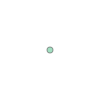

In [59]:
firts_point_sl = Point([df['x'].head(1),df['y'].head(1)])
firts_point_sl

In [60]:
segments_1 = LineString([last_point_rs,firts_point_sl ])
print(segments_1)

LINESTRING (-9.444252715896567 37.11873424980533, -9.6004167 36.9664169)


#==============================

Shapely LineString: LINESTRING (-9.017528720254575 36.513638062999206, -8.853478853409399 36.475957644366346)


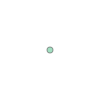

In [61]:
# Create ´connecting lines
first_line_end_seg = segments_after.head(1)

geom =first_line_end_seg['geometry']
# Access one of the LineString geometries from the GeoSeries (for example, the first one)
line_gdf = first_line_end_seg.iloc[0]

# Convert the GeoDataFrame to a Shapely LineString
line_shapely = LineString(line_gdf.geometry.coords)

print("Shapely LineString:", line_shapely)
x, y = line_shapely.xy
d = {'x': x, 'y': y}
df = pd.DataFrame(data = d)
first_point_rs = Point([df['x'].head(1),df['y'].head(1)])
first_point_rs

LINESTRING (-9.6004167 36.9664169, -9.5484167 36.7865011, -9.42025 36.6758737, -9.2920833 36.565087, -9.0658333 36.5140044)
<class 'shapely.geometry.linestring.LineString'>


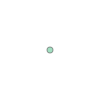

In [62]:
seperation_lane = gdf_ways.loc[mind_dist_index]
print(seperation_lane.geom)
print(type(seperation_lane.geom))
x, y = seperation_lane.geom.xy
d = {'x': x, 'y': y}
df = pd.DataFrame(data = d)
last_point_sl = Point([df['x'].tail(1),df['y'].tail(1)])
last_point_sl

In [63]:
segments_2 = LineString([last_point_sl,first_point_rs ])
print(segments_2)

LINESTRING (-9.0658333 36.5140044, -9.017528720254575 36.513638062999206)


## =================================================

In [64]:
# Create a new GeoDataFrame with the new LineString
first_line_Seg =  gpd.GeoDataFrame(geometry=[segments_1], crs=segments_before_df.crs)
seperation_lane = gpd.GeoDataFrame(geometry=[seperation_lane_geom], crs=segments_before_df.crs)
second_line_Seg =  gpd.GeoDataFrame(geometry=[segments_2], crs=segments_before_df.crs)

# Append the new GeoDataFrame to the existing one
#combined_gdf = segments_before_df.append(new_gdf, ignore_index=True)
combined_first_route_gdf = gpd.GeoDataFrame(pd.concat([segments_before_df, first_line_Seg], ignore_index=True), crs=segments_before_df.crs)
combined_gdf = gpd.GeoDataFrame(pd.concat([combined_first_route_gdf, seperation_lane], ignore_index=True), crs=segments_before_df.crs)
combined_last_route_seg = gpd.GeoDataFrame(pd.concat([combined_gdf, second_line_Seg], ignore_index=True), crs=segments_before_df.crs)
final_route = gpd.GeoDataFrame(pd.concat([combined_last_route_seg, segments_after], ignore_index=True), crs=segments_before_df.crs)
# Now combined_gdf contains the original LineStrings along with the new LineString
#print(combined_gdf)
# Now combined_gdf contains the original LineStrings along with the new LineString
print(final_route)

                                            geometry
0  LINESTRING (-9.55625 37.22111, -9.44425 37.11873)
1  LINESTRING (-9.44425 37.11873, -9.60042 36.96642)
2  LINESTRING (-9.60042 36.96642, -9.54842 36.786...
3  LINESTRING (-9.06583 36.51400, -9.01753 36.51364)
4  LINESTRING (-9.01753 36.51364, -8.85348 36.47596)


In [65]:
final_route.explore()

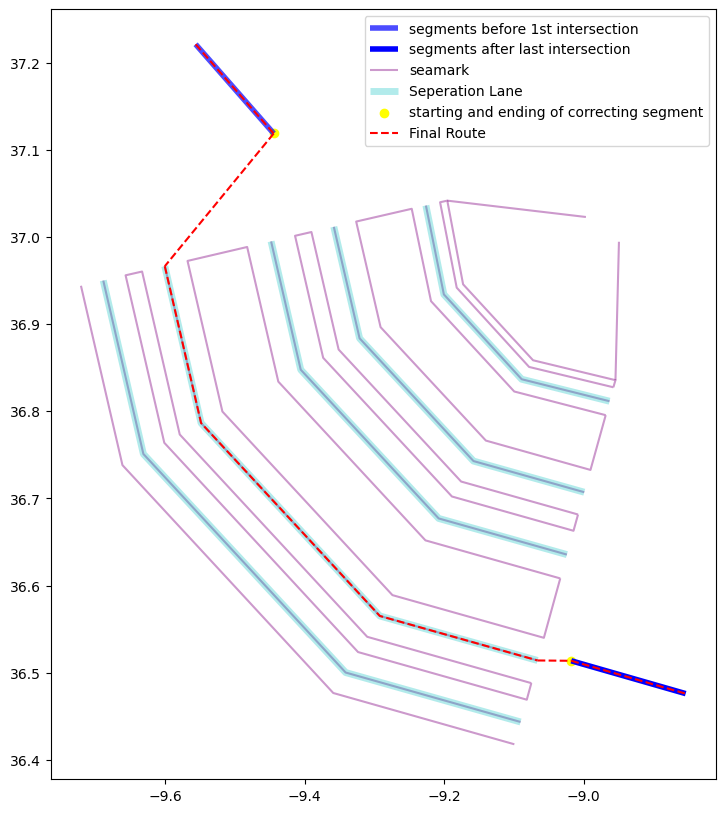

In [67]:
fig, ax = plt.subplots(figsize=(10,10))
segments_before_df.plot(ax=ax, color='blue',alpha=0.7,label='segments before 1st intersection', linewidth=4)
segments_after.plot(ax=ax, color='blue',label='segments after last intersection',  linewidth=4)
seamark_gdf.plot(ax=ax, color='purple', alpha=0.4, label='seamark')

gdf_ways.plot(ax=ax,  color='c',alpha=0.3, label='Seperation Lane',  linewidth=5)

p.plot(ax=ax, color='yellow', label='starting and ending of correcting segment' )
final_route.plot(ax=ax, color = 'red',linestyle='dashed', label='Final Route', linewidth=1.5)

ax.legend()
plt.show()